# Deconvolution of Kripton data

Deconvolution of Kripton data

In [233]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [235]:
import FEE as FE

In [236]:
from scipy import signal

In [237]:
import time

In [238]:
import pandas as pd

## Revised on:

In [239]:
print(time.strftime("%d/%m/%Y"))

11/11/2016


In [240]:
print(time.strftime("%H:%M:%S"))

02:23:15


In [241]:
def wait():
    """
    A simple convenience name for raw_input
    """
    raw_input("Press a key...")

###  Code exercized

In [242]:
!pep8 ../Sierpe/FEE.py

../Sierpe/FEE.py:1:1: E902 IOError: [Errno 2] No such file or directory: '../Sierpe/FEE.py'


In [243]:
!pyflakes ../Sierpe/FEE.py

../Sierpe/FEE.py: No such file or directory


In [244]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### Deconvolution function

#### coeff_clean = freq_zerod

Nominal values:


C1=3100 nF

R1=1567 ohm

f_sample = (1/25 ns)

freq_zero = 1/(R1*C1);

freq_zerod = freq_zero / (f_sample*np.pi)

#### coef_blr=fee.freq_LHPFd*np.pi

freq_LHPFd = freq_LHPF/(f_sample*np.pi)

freq_LHPF = 1./(R * C)

In [245]:
def find_baseline(signal_i, mau_len=1000):

    """
    1) compute baseline using the first blevt events
    2) compute noise rms using first blevt events

    """
    
    nm = mau_len
    len_signal_i = len(signal_i)
    mau = np.zeros(nm, dtype=np.double)
    bmau = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch
#    allows to compute the baseline of the signal

    mau = signal.lfilter(bmau,1, signal_i[0:nm])
    baseline = mau[nm-1]
    noise_rms = np.std(signal_i[0:nm],ddof=1)
    print ("baseline = {} noise (LSB_rms) = {}".format(baseline, noise_rms))
    return baseline, noise_rms

In [246]:
def discharge(length_d=5000, tau=2500, compress=0.005):
    t_discharge = np.arange(0,length_d,1,dtype=np.double)
    discharge_curve = compress*(1-1/(1+np.exp(-(t_discharge-length_d/2)/tau)))+(1-compress)
    return discharge_curve

def BLR_vhb(signal_daq, coef, thr = 2, nm_acum_MAU=1, acum_FLOOR=1000, 
            C1=3100E-9, filter=False):

    """
    Only for calibration

    """
    base_aux,noise=find_baseline(signal_daq)
    baseline = 4096.0-base_aux
    signal_daq = (4096.0 - signal_daq) - baseline
    
    #print ("NOISE (LSB_rms)= ",np.std(signal_daq[0:500],ddof=1))

    if (filter==True):
        #C1=3100E-9; #C1=2714E-9;
        R1=1567;
        f_sample = (1/25E-9)
        freq_zero = 1/(R1*C1);
        freq_zerod = freq_zero / (f_sample*np.pi)
        b_cf, a_cf = signal.butter(1, freq_zerod, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
    

    
    len_signal_daq = len(signal_daq)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    j_reg = np.zeros(len_signal_daq, dtype=np.double)
    
    
    BASELINE = np.mean(signal_daq[0:1000])

#----------

    discharge_length = 5000
    discharge_curve = discharge(length_d=discharge_length, tau=2500, compress=0.0025)
    j=0

    for k in range(0,len_signal_daq): 

            
        trigger_linep = BASELINE + thr #MAU[k-1] + thr
        trigger_linen = BASELINE - thr #MAU[k-1] - thr

        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1]
        
        
        # condition: raw signal raises above trigger line and 
        if (signal_daq[k] > trigger_linep) or (acum[k-1] > acum_FLOOR):

            acum[k] = acum[k-1] + signal_daq[k] - BASELINE;
            j=0
                       
        else:

            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1]

            if (acum[k-1]>1):
                acum[k]=acum[k-1]*discharge_curve[j]
                if j<discharge_length-1:
                    j=j+1
                else:
                    j=discharge_length-1
            else:
                acum[k]=0
                j=0
        j_reg[k]=j        
            



    return  signal_r,acum

In [247]:
def deconvolve_signal(signal_daq, mau_len=1000, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr1=5, thr2=1, thr3=1,
                      filter_c=True, kmin=0, kmax = 0):

    signal_r, acum = BLR_vhb(signal_daq=signal_daq, coef=coef_blr, nm_acum_MAU=1, acum_FLOOR=1000,
                             thr = thr1, C1=coef_clean, filter=filter_c)
    
    len_signal_daq = len(signal_daq)
    sm = np.amax(signal_r)
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = np.zeros(len_signal_daq, dtype=np.double)
    BLR['wait_over'] = np.zeros(len_signal_daq, dtype=np.double)
    BLR['MAU'] = np.zeros(len_signal_daq, dtype=np.double)
    BLR['trigger_1'] = np.zeros(len_signal_daq, dtype=np.double)
    BLR['trigger_2'] = np.zeros(len_signal_daq, dtype=np.double)
    BLR['signal_daq'] = signal_daq
    BLR['sm'] = sm
    
    return  signal_r, BLR

#### List the files

In [248]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

El modificador no es v lido: "Users".


#### Open and inspect files

e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [249]:
kr2609 = tables.open_file('F:/DATOS_DAC/run_2609_kr.root.h5','r+')

In [250]:
kr2609

File(filename=F:/DATOS_DAC/run_2609_kr.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtblr (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/pmtrwf (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/sipmrwf (EArray(1365, 1792, 1200), shuffle, zlib(4)) ''
  atom := I

## Calibration data

In [251]:
pmtID = ['1','3','2','4',
         'C','B','A','9',
         '8','7','6','5']
elecID = [0, 18,  1, 19,  27, 26, 9,  8, 23, 22,  5,  4]
noise_rms = [0.7060,0.8744,0.7213,0.7624,
             0.7921,0.8660,0.7062,0.7278,
             0.7303,0.7160,0.7323,0.7206]
coef_c = [2.905447E-06,3.085705E-06,2.806061E-06,2.756265E-06,
          3.138766E-06,3.965176E-06,2.711644E-06,3.127641E-06,
          3.064543E-06,3.040463E-06,3.113604E-06,3.185979E-06]
coef_blr = [1.632411E-03,1.610050E-03,1.611104E-03,1.599356E-03,
            1.566958E-03,1.649618E-03,1.592963E-03,1.612068E-03,
            1.600683E-03,1.592718E-03,1.575192E-03,1.596322E-03]

In [252]:
dataPMT = pd.DataFrame({'pmtID': pmtID,'elecID': elecID,'noise_rms': noise_rms,
              'coef_c': coef_c,'coef_blr': coef_blr})

In [253]:
dataPMT

,coef_blr,coef_c,elecID,noise_rms,pmtID
0,0.001632,0.000003,0,0.7060,1
1,0.001610,0.000003,18,0.8744,3
2,0.001611,0.000003,1,0.7213,2
3,0.001599,0.000003,19,0.7624,4
4,0.001567,0.000003,27,0.7921,C
5,0.001650,0.000004,26,0.8660,B
6,0.001593,0.000003,9,0.7062,A
7,0.001612,0.000003,8,0.7278,9
8,0.001601,0.000003,23,0.7303,8
9,0.001593,0.000003,22,0.7160,7


## Testing new deconvolution with Kripton data

In [254]:
pmtrwf = kr2609.root.RD.pmtrwf

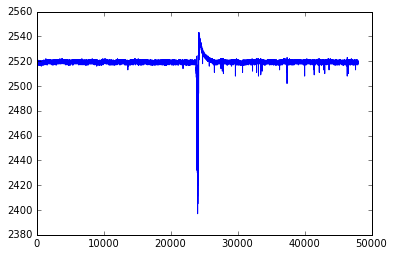

In [255]:
plt.plot(pmtrwf[0,0])

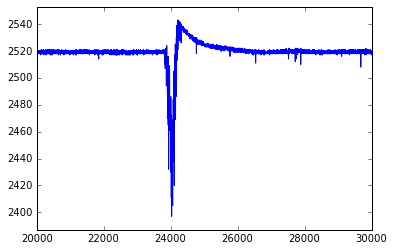

In [256]:
mpl.plts(pmtrwf[0,0], signal_start=20000, signal_end=30000, offset=10)

## Approach 1: thr3 = 1

This approach results in a step at the end of the signal, but the accumulator is stable.

In [257]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=1.0, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2518.755 noise (LSB_rms) = 0.790949177002


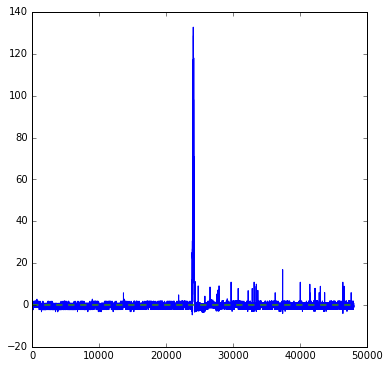

In [258]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

#### S1 likes

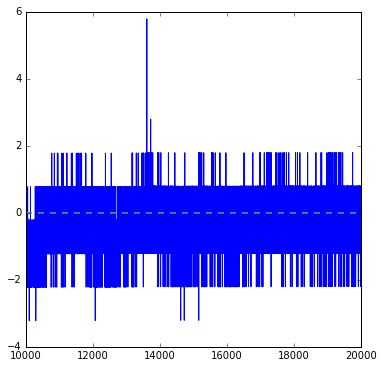

In [259]:
plt.figure(figsize=(6, 6))
xmin=10000
xmax=20000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

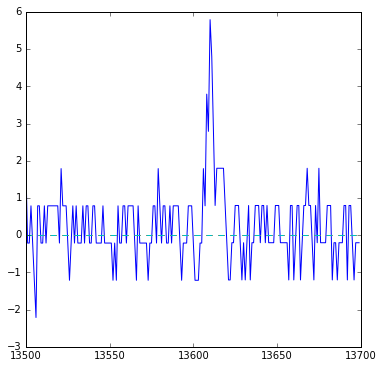

In [260]:
plt.figure(figsize=(6, 6))
xmin=13500
xmax=13700
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

Pulse_on is activated by the S1 above threshold, and switched off as soon as the spike returns to the baseline. Wait_over also switches off immediately since signal_r and signa_daq are identical at this point

### Start of S2

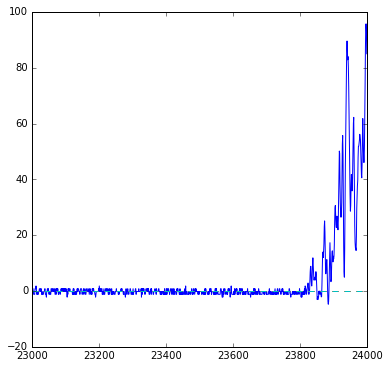

In [261]:
plt.figure(figsize=(6, 6))
xmin=23000
xmax=24000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

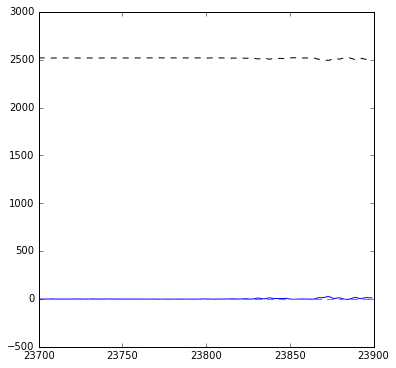

In [262]:
plt.figure(figsize=(6, 6))
xmin=23700
xmax=23900
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

pulse_on (wait_over) triggers on and off several times, following the natural fluctuations of the signal. Raw signal and recovered signal are still identical. 

### pulse on =1

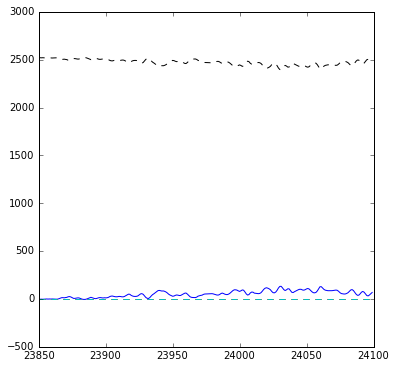

In [263]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

Signal has raised aboved threshold and pulse develops. The recovered signal keeps growing above DAQ signal.

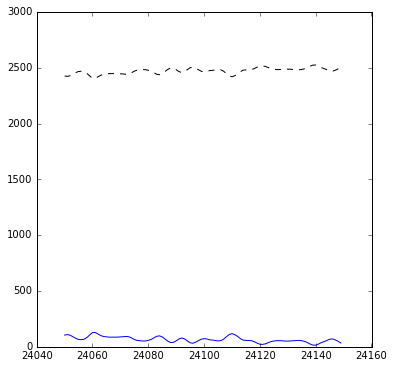

In [264]:
plt.figure(figsize=(6, 6))
xmin=24050
xmax=24150
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

### Wait over starts

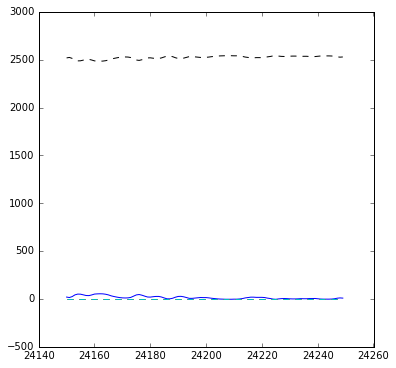

In [265]:
plt.figure(figsize=(6, 6))
xmin=24150
xmax=24250
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

The recovered signal crosses threshod and pulse_on switches off. Now the pulse continues recovering until the difference between the recovered signal and the raw signal is less than
~1 noise_rms

### Wait over

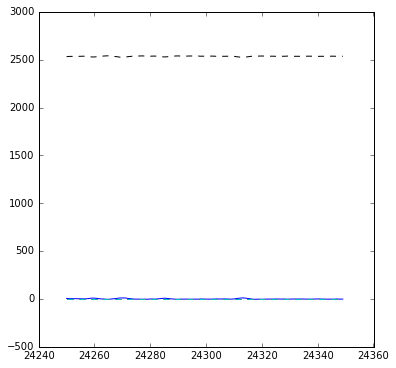

In [266]:
plt.figure(figsize=(6, 6))
xmin=24250
xmax=24350
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

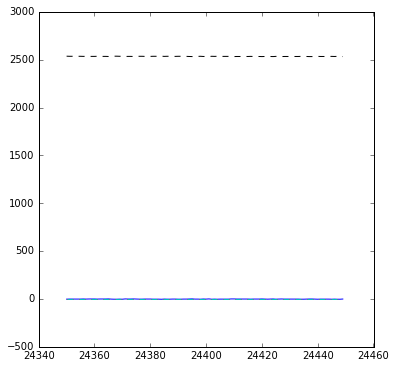

In [267]:
plt.figure(figsize=(6, 6))
xmin=24350
xmax=24450
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*15,'c--', linewidth=1)

As the signal raises well above threshold (no more pulse swich on/off), wait_over is 

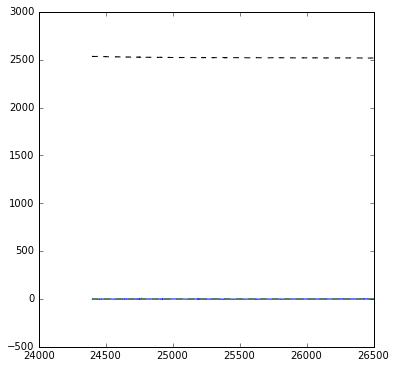

In [268]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 26500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

The recovered signal and the daq_signal meet a few counts below threshold, resulting in a step.

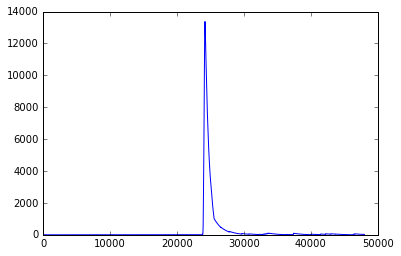

In [269]:
plt.plot(BLR['acum'])

The accumulator is well behaved.

## thr3 < 1

In [270]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2518.755 noise (LSB_rms) = 0.790949177002


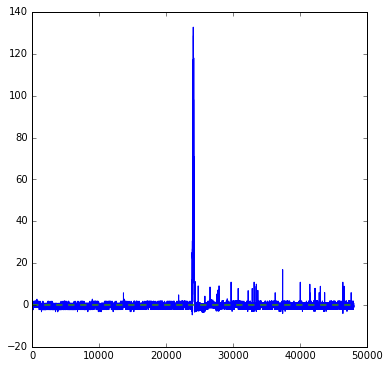

In [271]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

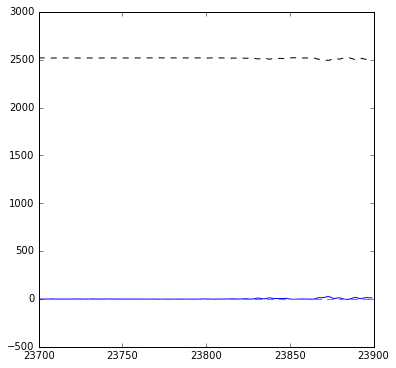

In [272]:
plt.figure(figsize=(6, 6))
xmin=23700
xmax=23900
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

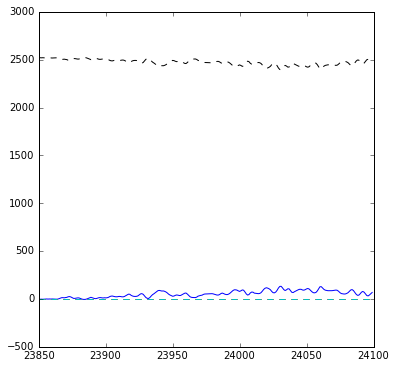

In [273]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

Setting th3 low (0.3) results in "cheating the system into recovery mode" from the start of the pulse. 

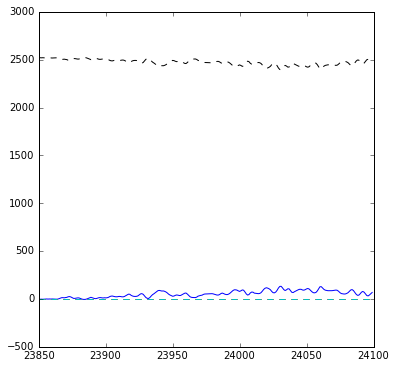

In [274]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

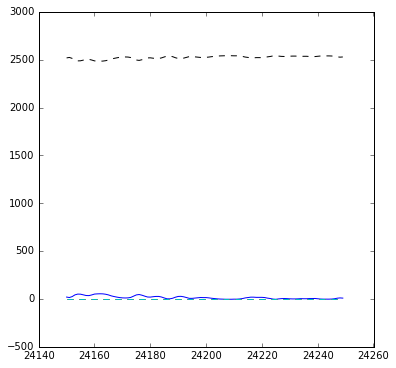

In [275]:
plt.figure(figsize=(6, 6))
xmin=24150
xmax=24250
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

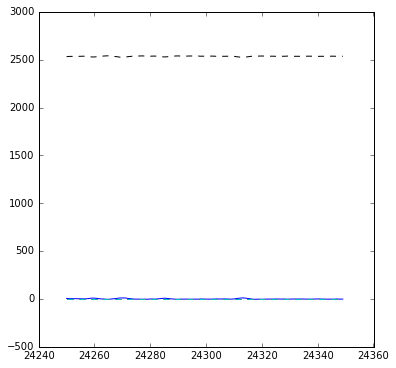

In [276]:
plt.figure(figsize=(6, 6))
xmin=24250
xmax=24350
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

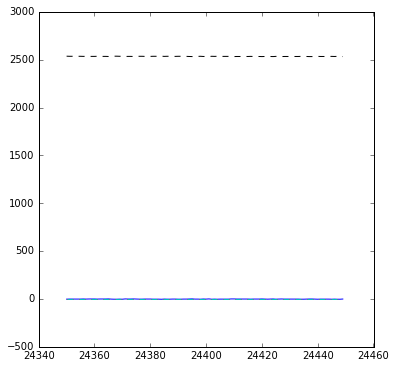

In [277]:
plt.figure(figsize=(6, 6))
xmin=24350
xmax=24450
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*15,'c--', linewidth=1)

recovered signal stays nearer zero

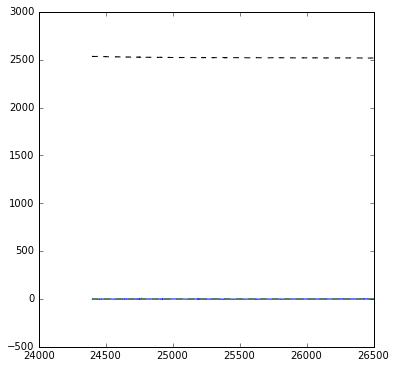

In [278]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 26500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

dip occurs later in the waveform (always needed since one has to adjust to raw waveform)

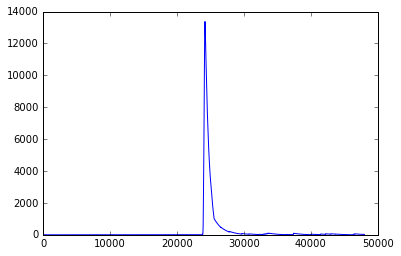

In [279]:
plt.plot(BLR['acum'])

In [280]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.1, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2518.755 noise (LSB_rms) = 0.790949177002


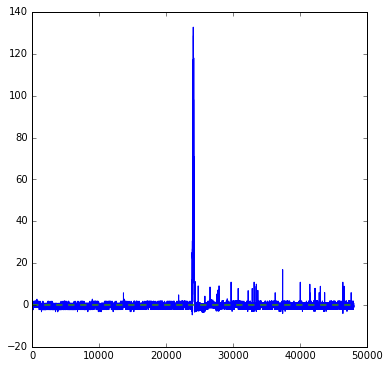

In [281]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

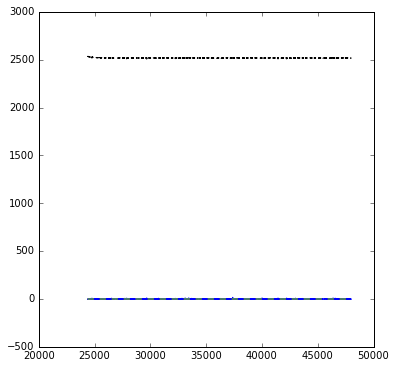

In [282]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

always in mode wait over (alwasy recovering)

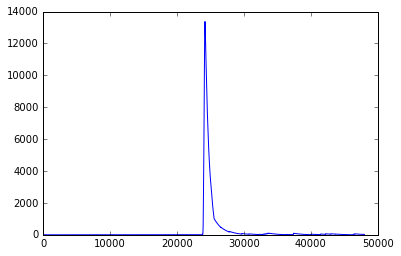

In [283]:
plt.plot(BLR['acum'])

In [284]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.2, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2518.755 noise (LSB_rms) = 0.790949177002


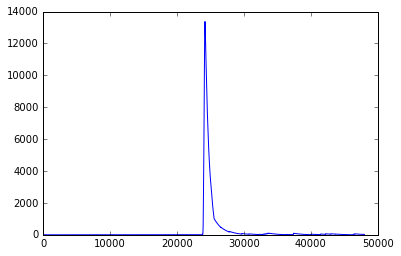

In [285]:
plt.plot(BLR['acum'])

In [286]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2518.755 noise (LSB_rms) = 0.790949177002


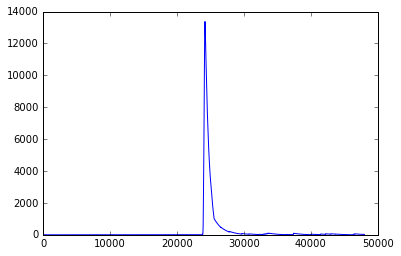

In [287]:
plt.plot(BLR['acum'])

The best value appears to be 0.3

## PMT2

In [288]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,1], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][1], 
                                  coef_blr=dataPMT['coef_blr'][1], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.976 noise (LSB_rms) = 0.761579939339


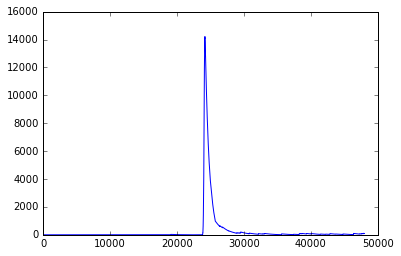

In [289]:
plt.plot(BLR['acum'])

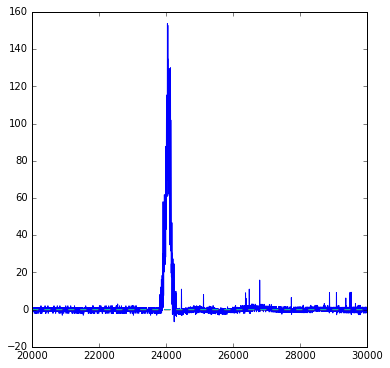

In [290]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT3

In [291]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,2], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][2], 
                                  coef_blr=dataPMT['coef_blr'][2], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2458.523 noise (LSB_rms) = 0.764234947549


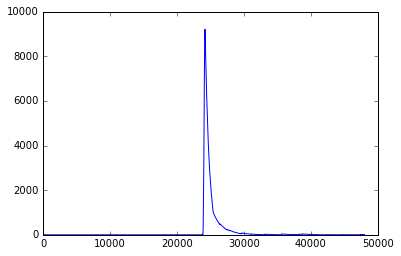

In [292]:
plt.plot(BLR['acum'])

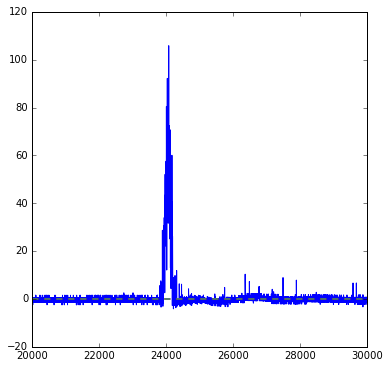

In [293]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT4

In [294]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,3], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][3], 
                                  coef_blr=dataPMT['coef_blr'][3], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2484.233 noise (LSB_rms) = 0.738414691252


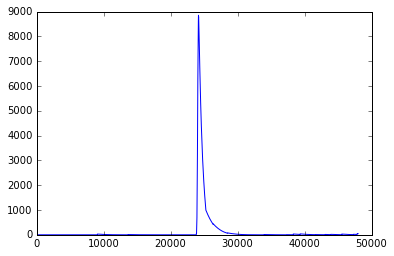

In [295]:
plt.plot(BLR['acum'])

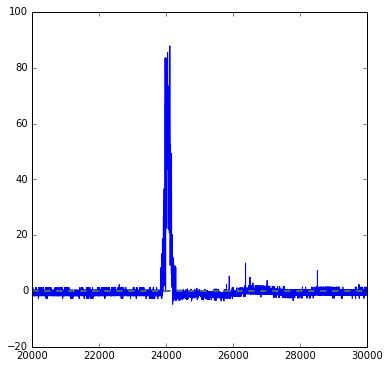

In [296]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT5

In [297]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,4], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][4], 
                                  coef_blr=dataPMT['coef_blr'][4], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2469.805 noise (LSB_rms) = 0.783318957123


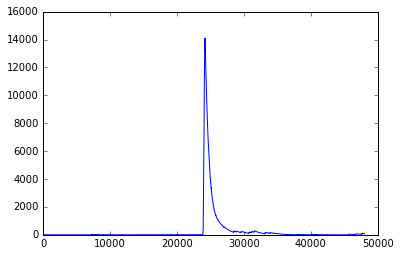

In [298]:
plt.plot(BLR['acum'])

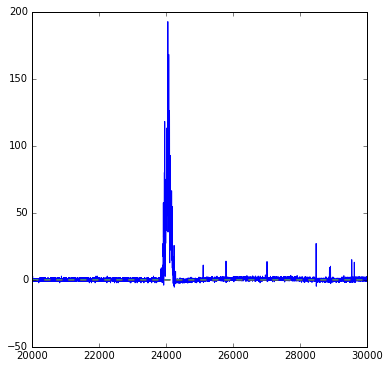

In [299]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT6

In [300]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,5], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][5], 
                                  coef_blr=dataPMT['coef_blr'][5], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2528.388 noise (LSB_rms) = 0.737563556583


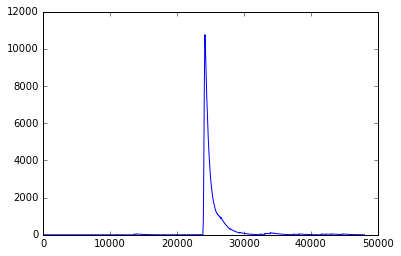

In [301]:
plt.plot(BLR['acum'])

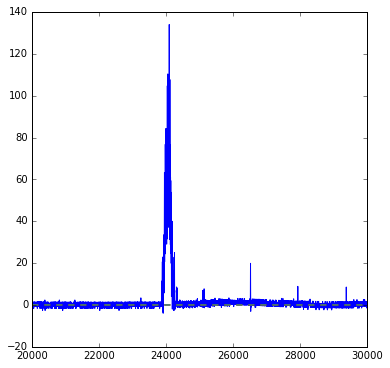

In [302]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT7

In [303]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,6], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][6], 
                                  coef_blr=dataPMT['coef_blr'][6], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2502.72 noise (LSB_rms) = 0.777305734061


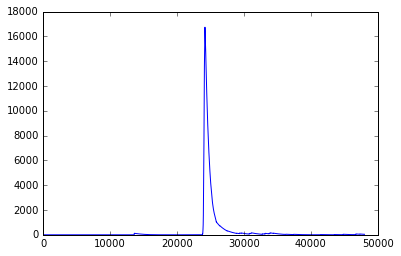

In [304]:
plt.plot(BLR['acum'])

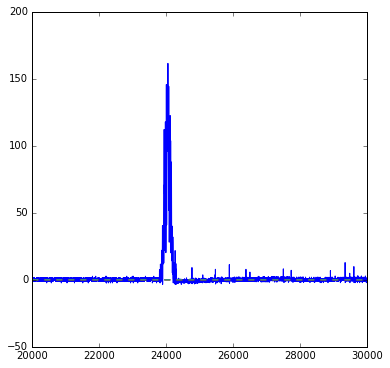

In [305]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT8

In [306]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,7], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][7], 
                                  coef_blr=dataPMT['coef_blr'][7], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2492.591 noise (LSB_rms) = 0.811404570715


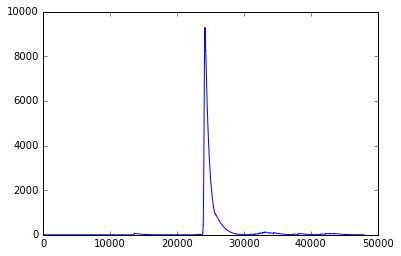

In [307]:
plt.plot(BLR['acum'])

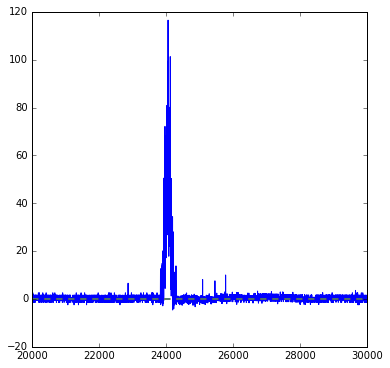

In [308]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT9

In [309]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,8], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][8], 
                                  coef_blr=dataPMT['coef_blr'][8], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2491.293 noise (LSB_rms) = 0.780871795342


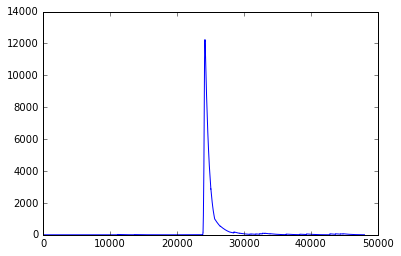

In [310]:
plt.plot(BLR['acum'])

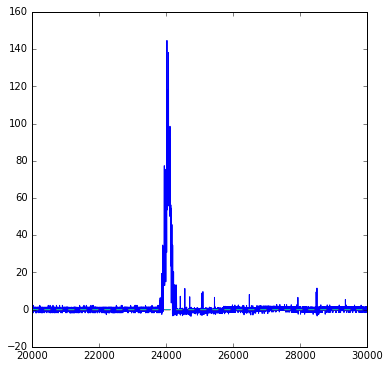

In [311]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT10

In [312]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,9], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][9], 
                                  coef_blr=dataPMT['coef_blr'][9], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2498.932 noise (LSB_rms) = 0.752291128448


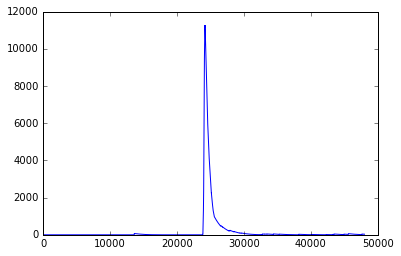

In [313]:
plt.plot(BLR['acum'])

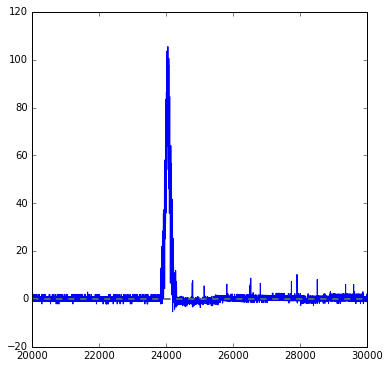

In [314]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT11

In [315]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,10], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][10], 
                                  coef_blr=dataPMT['coef_blr'][10], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2502.212 noise (LSB_rms) = 0.741353900378


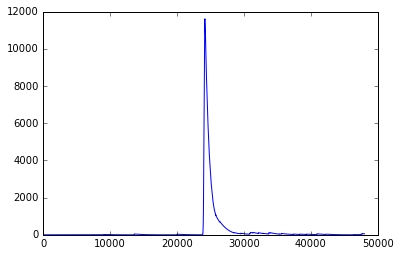

In [316]:
plt.plot(BLR['acum'])

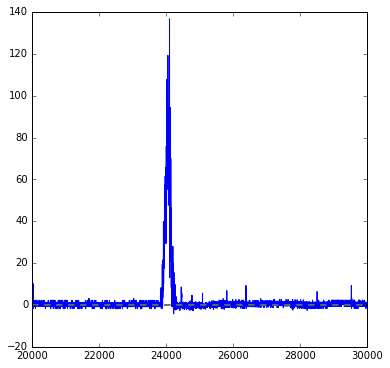

In [317]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT12

In [318]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,11], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][11], 
                                  coef_blr=dataPMT['coef_blr'][11], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2504.593 noise (LSB_rms) = 0.733409086996


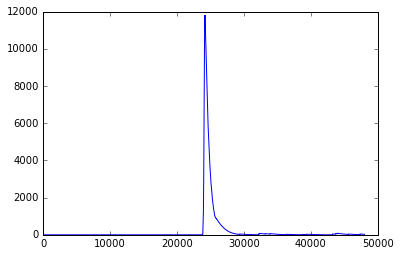

In [319]:
plt.plot(BLR['acum'])

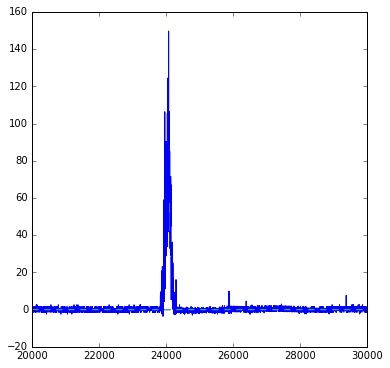

In [320]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

### Effect of cleaning not visible for short signals 

In [352]:
def deconv_pmt(pmtrwf,dataPMT, thr1 = 5, thr2=0, thr3=0.5, mau_len=128, 
               xmin=20000,
               xmax=30000, 
               event=0):
    """
    Deconvolution of a full event
    """
    NPMT = pmtrwf.shape[1]
    
    for i in range(NPMT):
        print('PMT number {}'.format(i+1))
        cc = dataPMT['coef_c'][i]
        cblr = dataPMT['coef_blr'][i]
        print('thr1 = {}, thr2 = {}, thr3 = {}, mau length = {}'.format(thr1,thr2, 
                                                                        thr3,mau_len))
        print('deconvoluting PMT = {} with coef_clean = {} coef_blr = {}'.format(i,cc,cblr))
                                                                                
        signal_r, BLR = deconvolve_signal(pmtrwf[event,i], 
                                          mau_len=mau_len, 
                                          coef_clean=cc,
                                          coef_blr=cblr, 
                                          thr1 = thr1, 
                                          thr2=thr2, 
                                          thr3=thr3,
                                          filter_c=True)
        
        plt.plot(BLR['acum'])
        plt.show()
        wait()
        plt.figure(figsize=(6, 6))

        plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
        # plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
        plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)
        plt.show()
        wait()
        
    

PMT number 1
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2518.755 noise (LSB_rms) = 0.790949177002


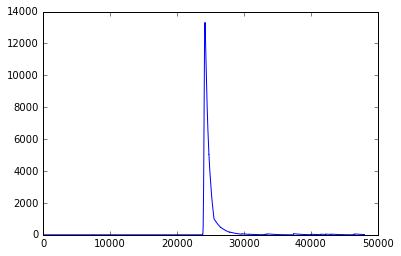

Press a key...


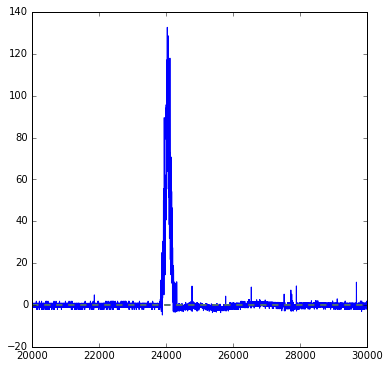

Press a key...
PMT number 2
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 1 with coef_clean = 3.085705e-06 coef_blr = 0.00161005
baseline = 2519.976 noise (LSB_rms) = 0.761579939339


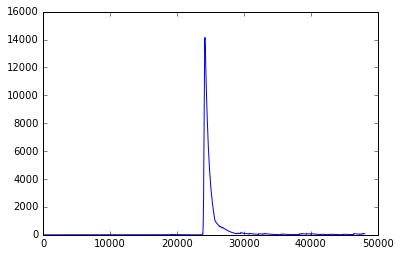

Press a key...


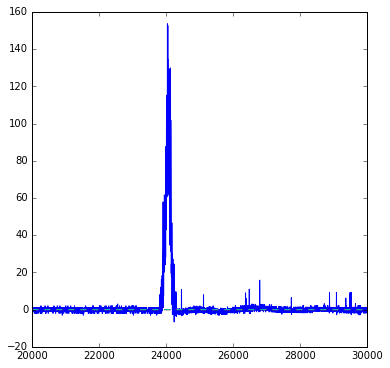

Press a key...
PMT number 3
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 2 with coef_clean = 2.806061e-06 coef_blr = 0.001611104
baseline = 2458.523 noise (LSB_rms) = 0.764234947549


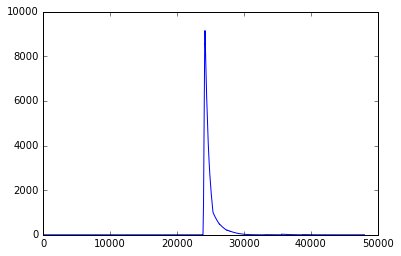

Press a key...


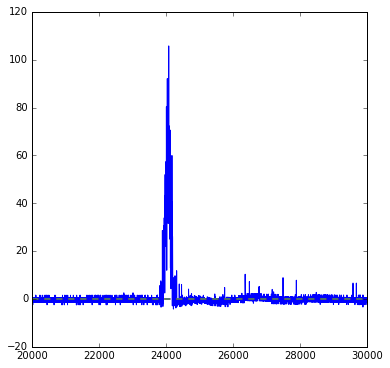

Press a key...
PMT number 4
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356
baseline = 2484.233 noise (LSB_rms) = 0.738414691252


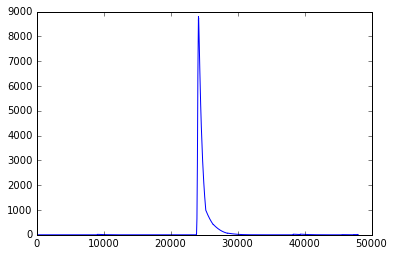

Press a key...


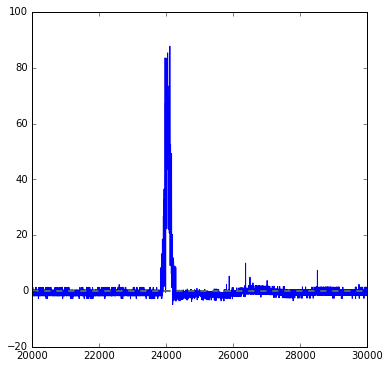

Press a key...
PMT number 5
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958
baseline = 2469.805 noise (LSB_rms) = 0.783318957123


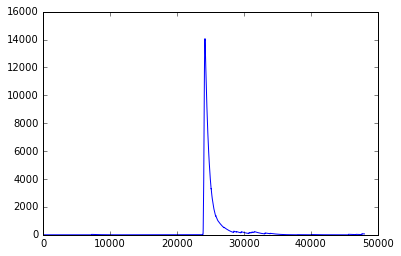

Press a key...


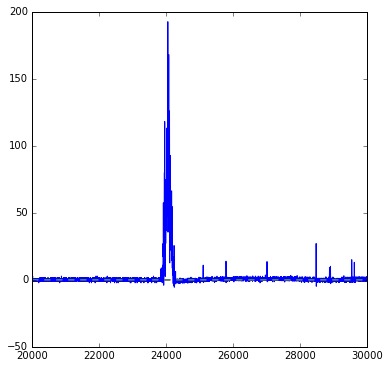

Press a key...
PMT number 6
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618
baseline = 2528.388 noise (LSB_rms) = 0.737563556583


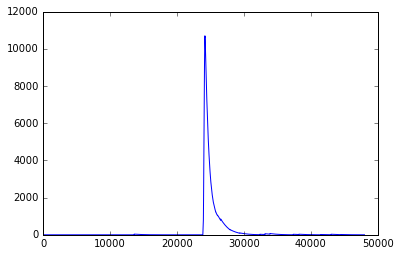

Press a key...


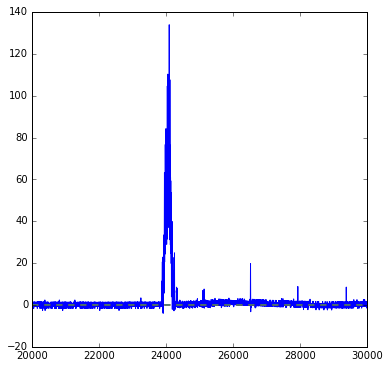

Press a key...
PMT number 7
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 6 with coef_clean = 2.711644e-06 coef_blr = 0.001592963
baseline = 2502.72 noise (LSB_rms) = 0.777305734061


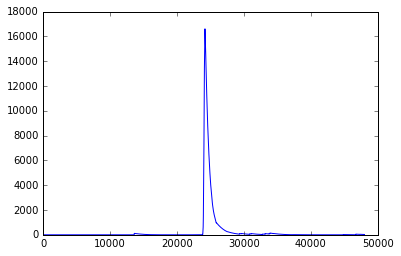

Press a key...


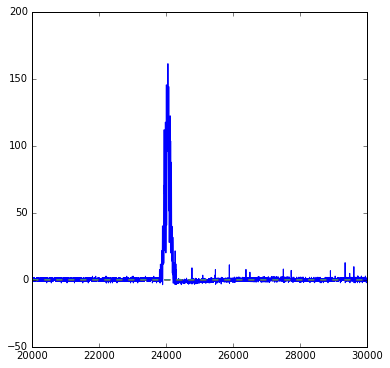

Press a key...
PMT number 8
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068
baseline = 2492.591 noise (LSB_rms) = 0.811404570715


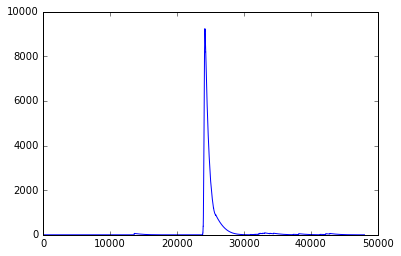

Press a key...


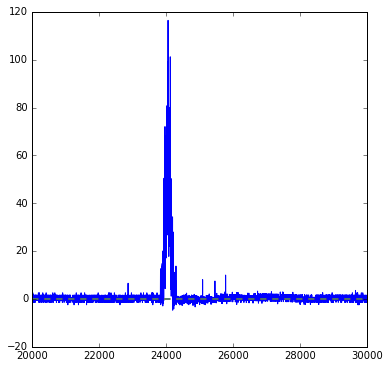

Press a key...
PMT number 9
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683
baseline = 2491.293 noise (LSB_rms) = 0.780871795342


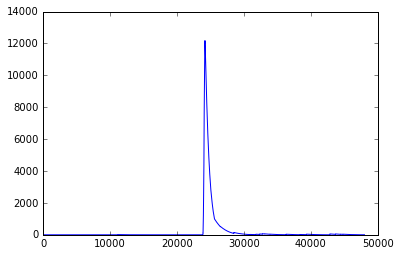

Press a key...


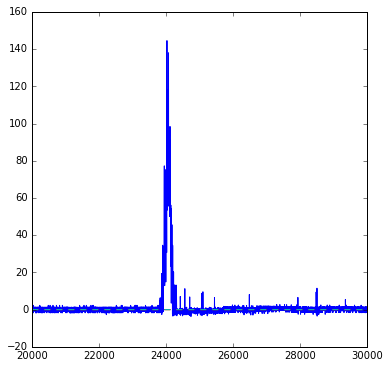

Press a key...
PMT number 10
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718
baseline = 2498.932 noise (LSB_rms) = 0.752291128448


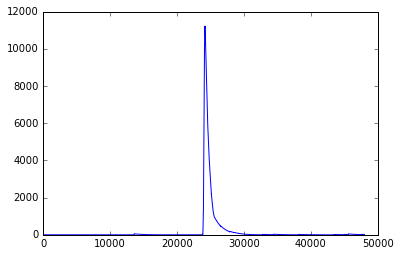

Press a key...


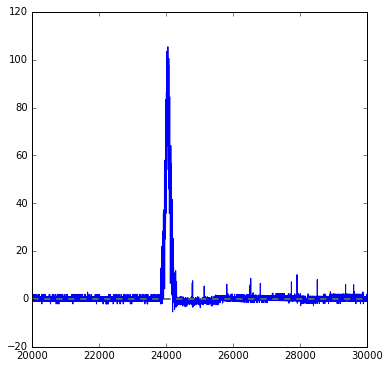

Press a key...
PMT number 11
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192
baseline = 2502.212 noise (LSB_rms) = 0.741353900378


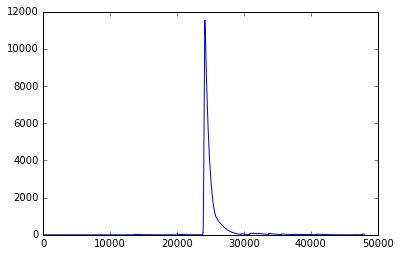

Press a key...


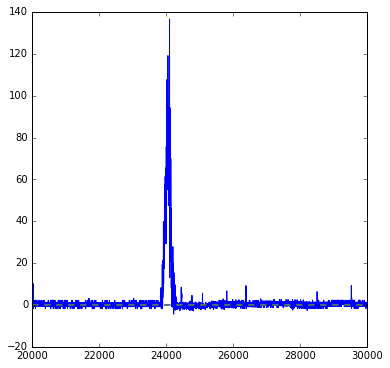

Press a key...
PMT number 12
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322
baseline = 2504.593 noise (LSB_rms) = 0.733409086996


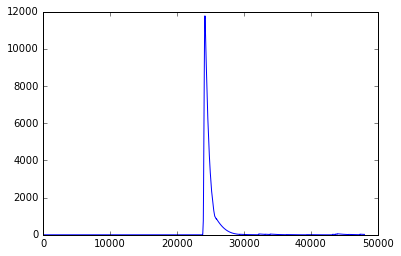

Press a key...


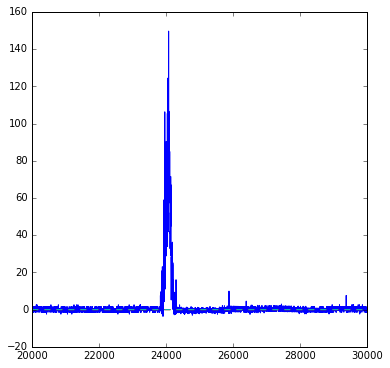

Press a key...


In [353]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=0.3, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

PMT number 1
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2518.755 noise (LSB_rms) = 0.790949177002


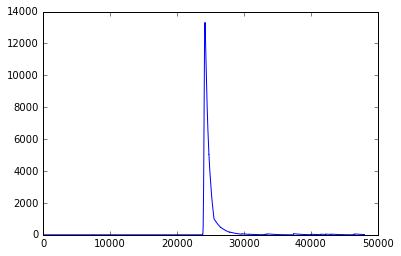

Press a key...


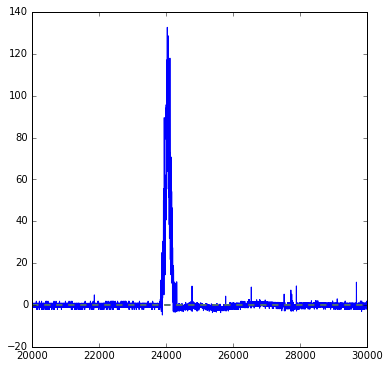

Press a key...
PMT number 2
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 1 with coef_clean = 3.085705e-06 coef_blr = 0.00161005
baseline = 2519.976 noise (LSB_rms) = 0.761579939339


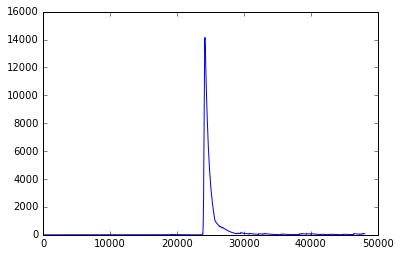

Press a key...


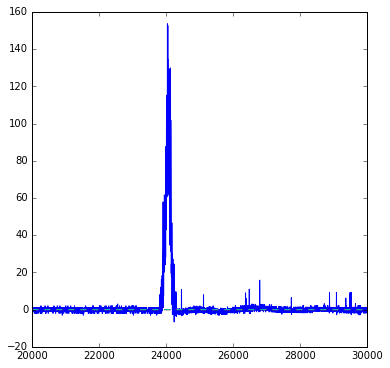

Press a key...
PMT number 3
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 2 with coef_clean = 2.806061e-06 coef_blr = 0.001611104
baseline = 2458.523 noise (LSB_rms) = 0.764234947549


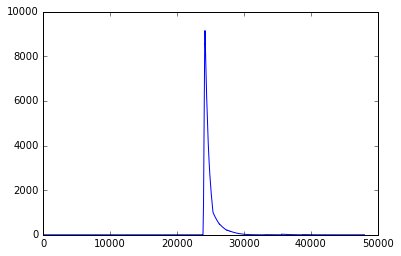

Press a key...


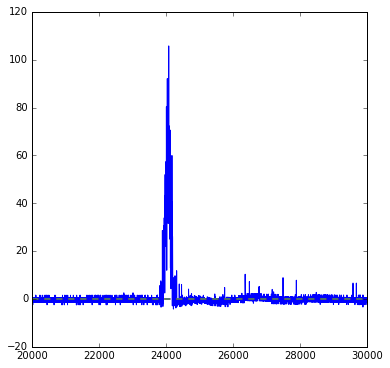

Press a key...
PMT number 4
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356
baseline = 2484.233 noise (LSB_rms) = 0.738414691252


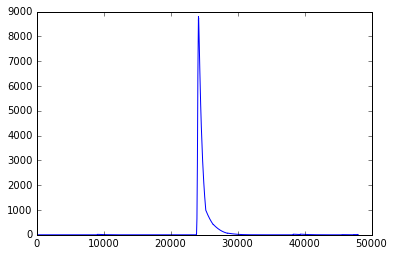

Press a key...


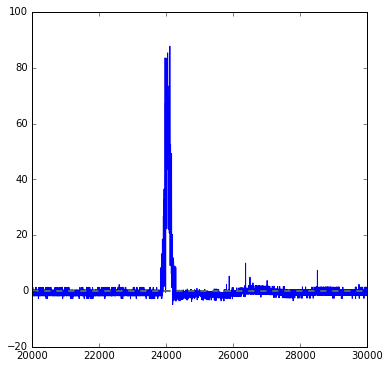

Press a key...
PMT number 5
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958
baseline = 2469.805 noise (LSB_rms) = 0.783318957123


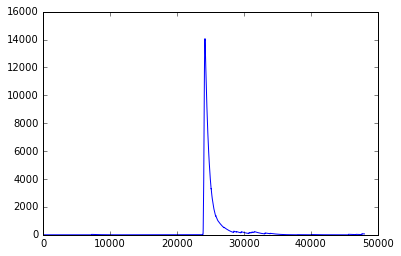

Press a key...


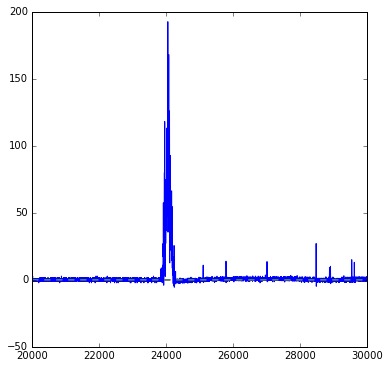

Press a key...
PMT number 6
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618
baseline = 2528.388 noise (LSB_rms) = 0.737563556583


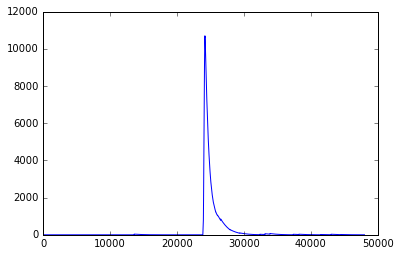

Press a key...


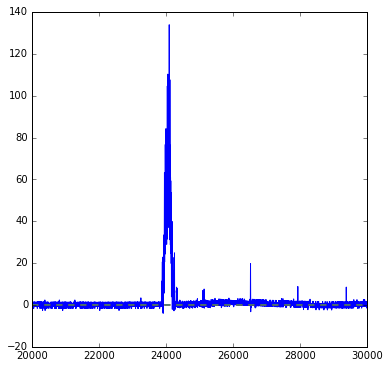

Press a key...
PMT number 7
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 6 with coef_clean = 2.711644e-06 coef_blr = 0.001592963
baseline = 2502.72 noise (LSB_rms) = 0.777305734061


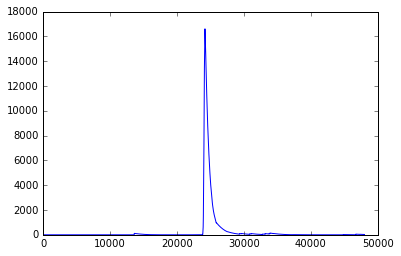

Press a key...


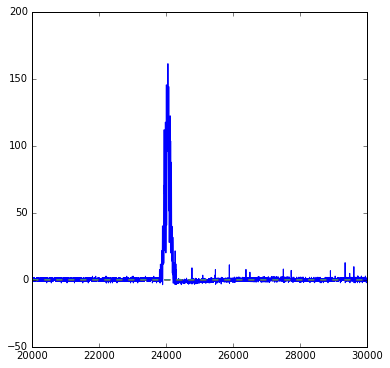

Press a key...
PMT number 8
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068
baseline = 2492.591 noise (LSB_rms) = 0.811404570715


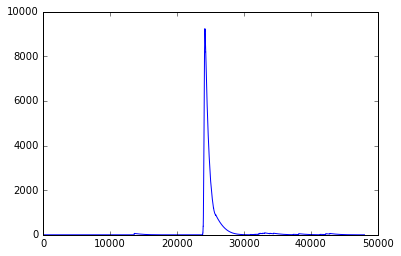

Press a key...


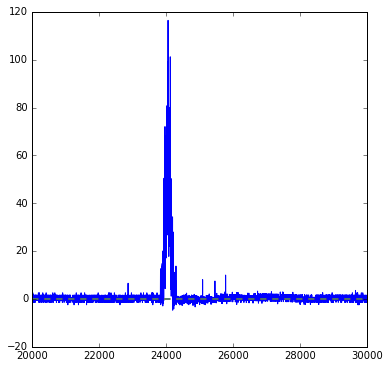

Press a key...
PMT number 9
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683
baseline = 2491.293 noise (LSB_rms) = 0.780871795342


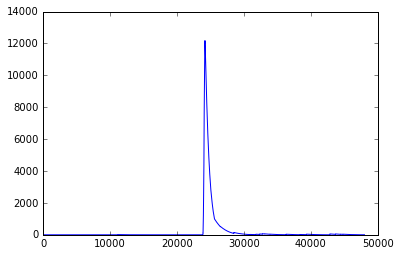

Press a key...


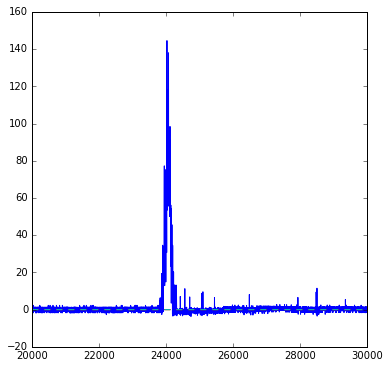

Press a key...
PMT number 10
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718
baseline = 2498.932 noise (LSB_rms) = 0.752291128448


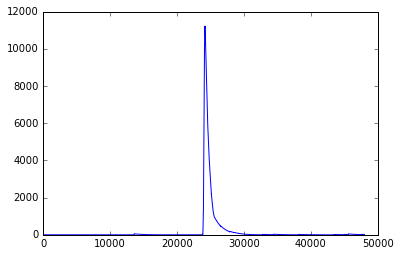

Press a key...


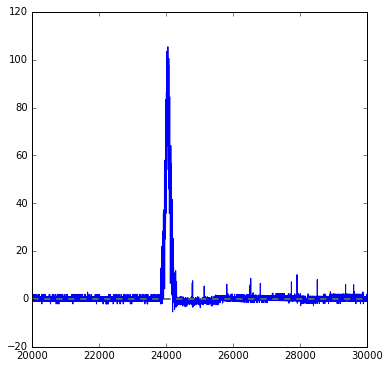

Press a key...
PMT number 11
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192
baseline = 2502.212 noise (LSB_rms) = 0.741353900378


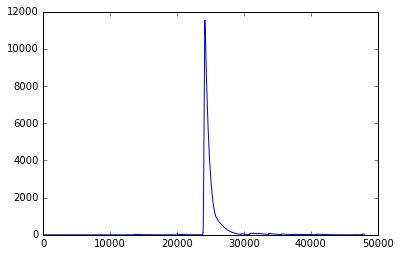

Press a key...


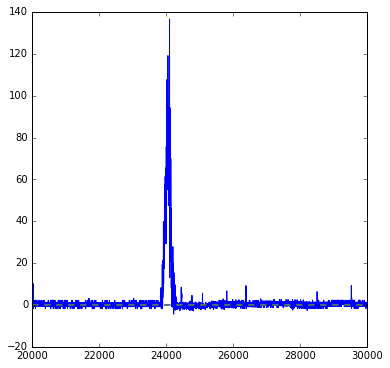

Press a key...
PMT number 12
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322
baseline = 2504.593 noise (LSB_rms) = 0.733409086996


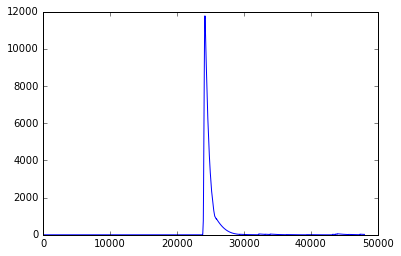

Press a key...


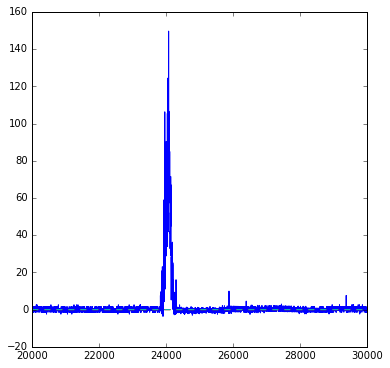

Press a key...


In [354]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=0.5, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

PMT number 1
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2518.755 noise (LSB_rms) = 0.790949177002


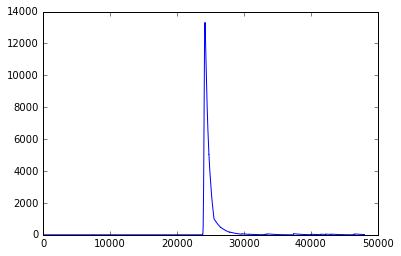

Press a key...


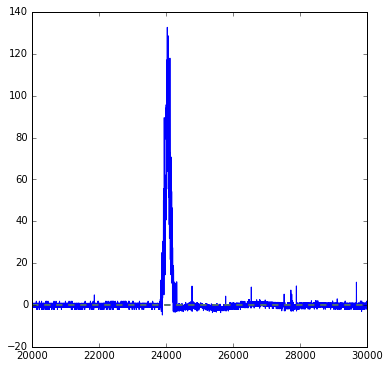

Press a key...
PMT number 2
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 1 with coef_clean = 3.085705e-06 coef_blr = 0.00161005
baseline = 2519.976 noise (LSB_rms) = 0.761579939339


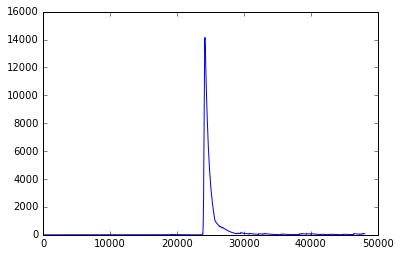

Press a key...


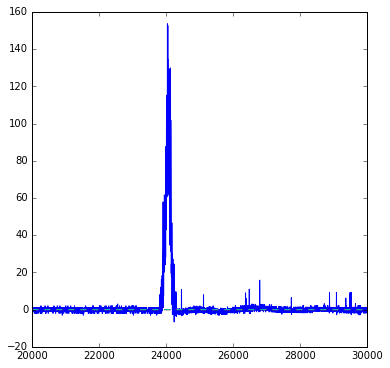

Press a key...
PMT number 3
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 2 with coef_clean = 2.806061e-06 coef_blr = 0.001611104
baseline = 2458.523 noise (LSB_rms) = 0.764234947549


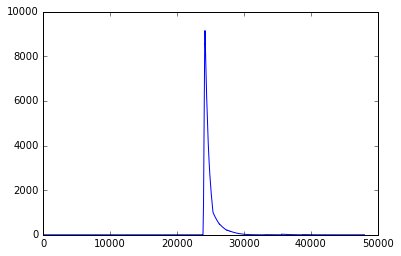

Press a key...


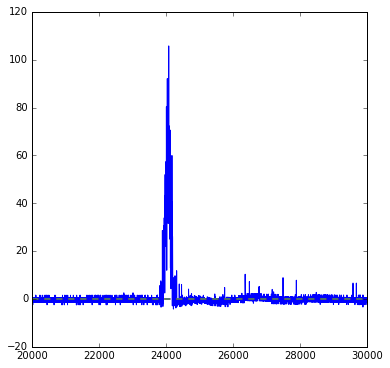

Press a key...
PMT number 4
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356
baseline = 2484.233 noise (LSB_rms) = 0.738414691252


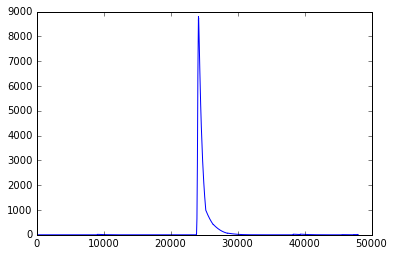

Press a key...


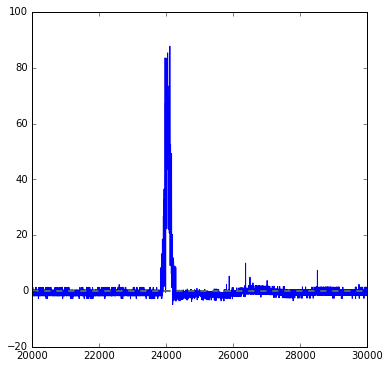

Press a key...
PMT number 5
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958
baseline = 2469.805 noise (LSB_rms) = 0.783318957123


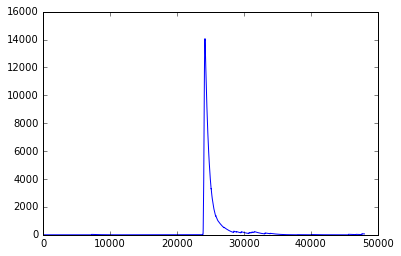

Press a key...


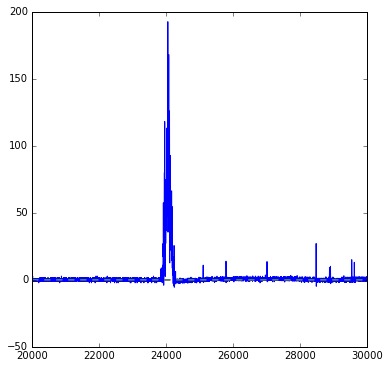

Press a key...
PMT number 6
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618
baseline = 2528.388 noise (LSB_rms) = 0.737563556583


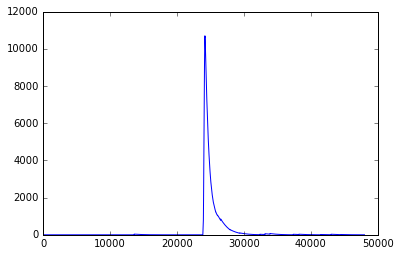

Press a key...


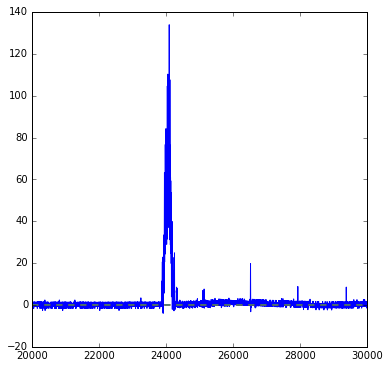

Press a key...
PMT number 7
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 6 with coef_clean = 2.711644e-06 coef_blr = 0.001592963
baseline = 2502.72 noise (LSB_rms) = 0.777305734061


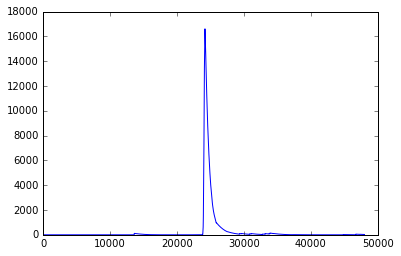

Press a key...


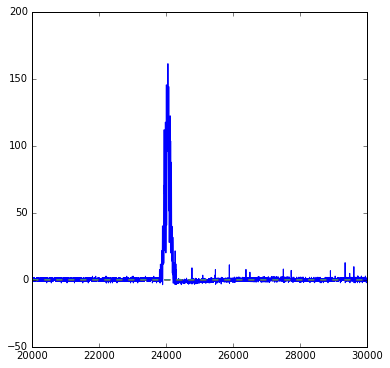

Press a key...
PMT number 8
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068
baseline = 2492.591 noise (LSB_rms) = 0.811404570715


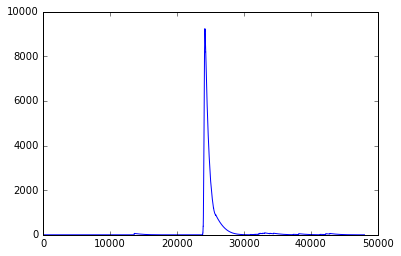

Press a key...


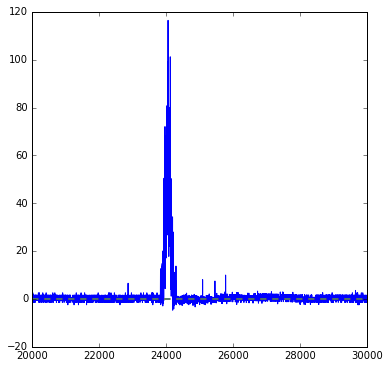

Press a key...
PMT number 9
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683
baseline = 2491.293 noise (LSB_rms) = 0.780871795342


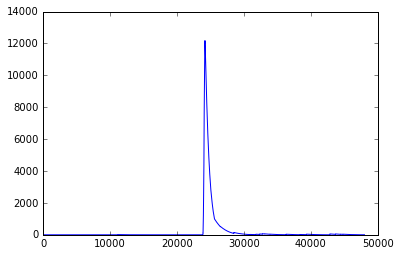

Press a key...


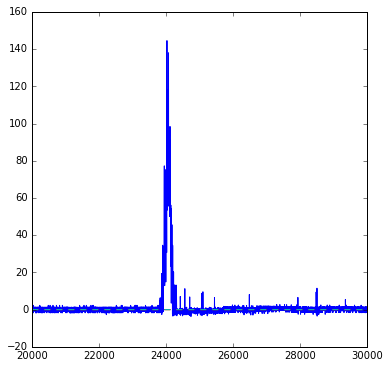

Press a key...
PMT number 10
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718
baseline = 2498.932 noise (LSB_rms) = 0.752291128448


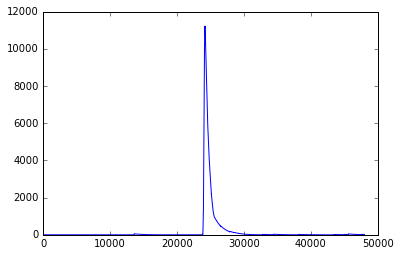

Press a key...


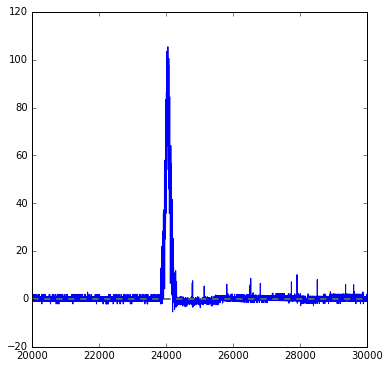

Press a key...
PMT number 11
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192
baseline = 2502.212 noise (LSB_rms) = 0.741353900378


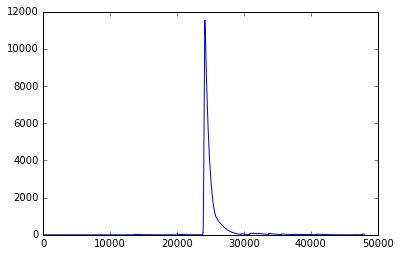

Press a key...


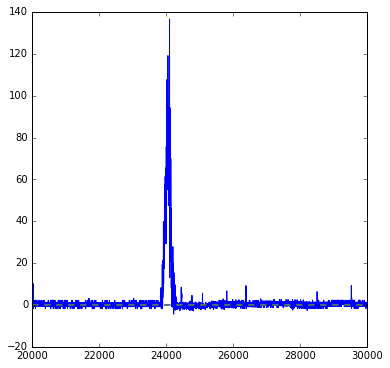

Press a key...
PMT number 12
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322
baseline = 2504.593 noise (LSB_rms) = 0.733409086996


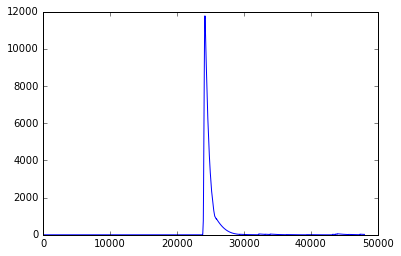

Press a key...


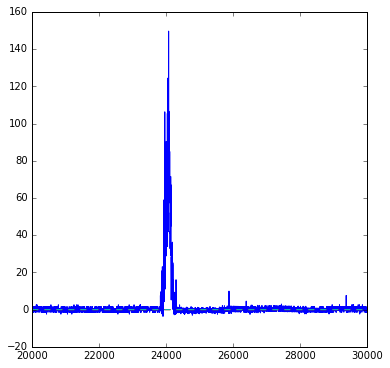

Press a key...


In [355]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=1.0, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

Why some PMTs show a deep and others do not? Deconvolution coefficients?

## check with MC data

In [356]:
def fee_response(h5f, event=0, pmt=0):
    """
    returns:
    input function (after daq decimation)
    convoluted function (after FEE)
    recovered function (after cleaning filter and BLR)
    all in adc counts
    """
    pmtrd = h5f.root.pmtrd
    spe = FE.SPE()
    signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
    signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc(fee)  #in adc counts
    signal_daq = FE.noise_adc(fee, signal_fee)
    
    return signal_d*FE.i_to_adc(fee), signal_daq

In [357]:
e40 = tables.open_file('F:/DATOS_DAC/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [358]:
signal_d, signal_daq = fee_response(e40, event=0, pmt=0)

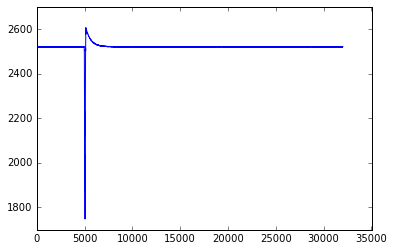

In [359]:
plt.plot(2520 - signal_daq)

In [360]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)

In [361]:
freq_zero = 1./(fee.R1*fee.C1)
freq_zerod = freq_zero/(fee.f_sample*np.pi)
print('coef_c = {}'.format(freq_zerod))

coef_c = 1.87116159952e-06


In [362]:
print('coef_blr = {}'.format(fee.freq_LHPFd*np.pi)) 
    

coef_blr = 0.00192400951255


In [363]:
signal_i = 2520 - signal_daq

In [364]:
signal_r, BLR = deconvolve_signal(signal_i, mau_len=128, 
                                  coef_clean=freq_zerod, 
                                  coef_blr=fee.freq_LHPFd*np.pi, 
                                  thr1 = 5, thr2 = 0, thr3=0.3)

baseline = 2519.97310263 noise (LSB_rms) = 0.339714834763


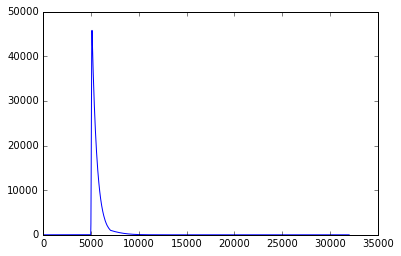

In [365]:
plt.plot(BLR['acum'])

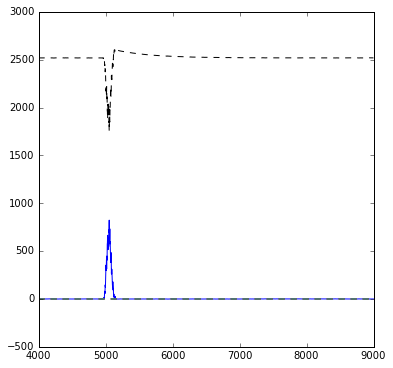

In [366]:
plt.figure(figsize=(6, 6))
xmin=4000
xmax=9000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*BLR['sm'],'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*BLR['sm'],'c--', linewidth=1)

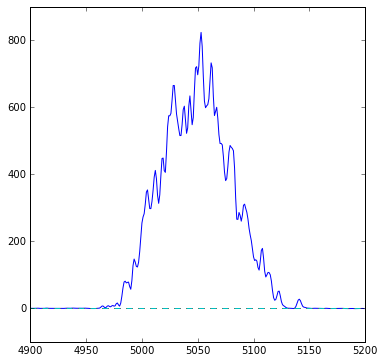

In [367]:
plt.figure(figsize=(6, 6))
xmin=4900
xmax=5200
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*BLR['sm'],'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*BLR['sm'],'c--', linewidth=1)

In [368]:
e_mc = np.sum(signal_r[4950:5150])

In [369]:
e_mc/20.

2628.9386679400877

In [370]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,5], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][5], 
                                  coef_blr=dataPMT['coef_blr'][5], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2528.388 noise (LSB_rms) = 0.737563556583


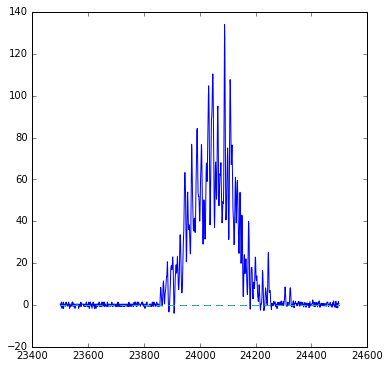

In [371]:
plt.figure(figsize=(6, 6))
xmin=23500
xmax=24500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

In [372]:
e_data = np.sum(signal_r[23859:24250])

In [373]:
e_data/20.

695.83543091973672

In [374]:
e_mc/e_data

3.7781040618544344

There seems to be a factor 4 less light in the data than in the MC!

In [375]:
pmtrd = e40.root.pmtrd

In [376]:
np.sum(pmtrd[0,0])

1210

In [377]:
def get_energy(pmtea, event_list=[0]):
    """
    Takes the earray pmtea and a list of events and returns a DF
    with the sum of the energies for event_number
    """
    NPMT = pmtea.shape[1]
    epmt = np.zeros(NPMT)
    EPMT = []

    for i in event_list:
        for j in range(NPMT):
            epmt[j] = np.sum(pmtea[i, j])
        EPMT.append(epmt)

    return pd.DataFrame(EPMT)

In [378]:
epmtdf = get_energy(pmtrd, event_list=range(900))

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  900.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 1263.5 ,  1263.54,  1263.58,  1263.62,  1263.66,  1263.7 ,
         1263.74,  1263.78,  1263.82,  1263.86,  1263.9 ,  1263.94,
         1263.98,  1264.02,  1264.06,  1264.1 ,  1264.14,  1264.18,
         1264.22,  1264.26,  1264.3 ,  1264.34,  1264.38,  1264.42,
         1264.46,  1264.5 ]),
 <a list of 25 Patch objects>)

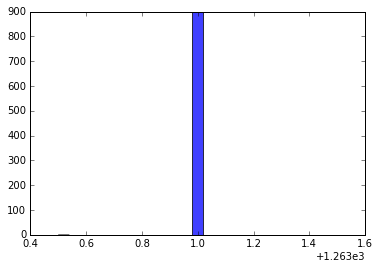

In [379]:
plt.hist(epmtdf[1], 25, histtype="bar", alpha=0.75)